In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# Response: Combine Rental and Housing Prices from 2011 and 2015

First we take rental data (median price per square foot of every zip code in America that we can find) from Zillow and clean it up by calculating the mean across 2011 and 2015 and adjusting the 2015 price for inflation.

In [2]:
rental_raw = pd.read_csv('data/Zip_ZriPerSqft_AllHomes.csv')
rental_raw.head(3)

RegionID  RegionName      City State     Metro CountyName  SizeRank  2010-11  2010-12  2011-01  2011-02  2011-03  2011-04  2011-05  2011-06  2011-07  2011-08  2011-09  2011-10  2011-11  2011-12  2012-01  2012-02  2012-03  2012-04  2012-05  2012-06  2012-07  2012-08  2012-09  2012-10  2012-11  2012-12  2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  2013-07  2013-08  2013-09  2013-10  2013-11  2013-12  2014-01  2014-02  2014-03  2014-04  2014-05  2014-06  2014-07  2014-08  2014-09  \
0     62080       11368  New York    NY  New York     Queens         1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN    1.868    1.894    1.914    1.948    1.962    1.968    1.962    1.970    1.962    1.942    1.942    1.982    2.000    1.998    1.998    1.994    2.006    2.030    2.066    2.088    2.096    2.094    2.082    2.110    2.116    2.126    2.134    2.146    2.168    2.194    2.204    2.218    2.230    2.264   
1     93144       79936   El Paso    TX   El Paso    El Paso         2    0.760    0.760    0.756    0.750    0.746    0.740    0.742    0.744    0.742     0.74    0.742    0.742    0.742    0.744    0.748    0.754    0.756    0.756    0.756    0.756    0.754    0.750    0.746    0.744    0.738    0.734    0.730    0.726    0.722    0.722    0.720    0.720    0.722    0.724    0.726    0.726    0.724    0.724    0.724    0.726    0.726    0.728    0.726    0.724    0.722    0.722    0.722   
2     84630       60629   Chicago    IL   Chicago       Cook         3    1.194    1.212    1.222    1.226    1.224    1.226    1.220    1.208    1.194     1.19    1.182    1.168    1.160    1.144    1.140    1.142    1.144    1.136    1.140    1.144    1.152    1.144    1.136    1.138    1.158    1.162    1.156    1.158    1.160    1.172    1.178    1.188    1.190    1.194    1.192    1.202    1.226    1.234    1.240    1.238    1.238    1.232    1.232    1.232    1.236    1.240    1.252   

   2014-10  2014-11  2014-12  2015-01  2015-02  2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  2015-09  2015-10  
0    2.282    2.316    2.304    2.298    2.306    2.310    2.306    2.290    2.284    2.280    2.312    2.354    2.404  
1    0.724    0.722    0.724    0.726    0.730    0.732    0.736    0.736    0.738    0.740    0.742    0.742    0.742  
2    1.256    1.266    1.254    1.246    1.238    1.238    1.240    1.238    1.240    1.244    1.254    1.258    1.258

In [3]:
col_11 = [col for col in rental_raw.columns if '2011' in col]
col_14_15 = rental_raw.columns[-12:]
rental_raw['agg_2011'] = rental_raw[col_11].mean(axis=1)
rental_raw['agg_2015'] = rental_raw[col_14_15].mean(axis=1)
rental_raw = rental_raw[['RegionName','agg_2011','agg_2015']]

infl_rate = 1.0573
rental_raw['agg_2015_adj'] = rental_raw.agg_2015/infl_rate
rental_raw['pct_delta'] = rental_raw.agg_2015_adj/rental_raw.agg_2011

In [4]:
houses = pd.read_pickle('data/response_houses.pkl')
houses.columns = ['h_'+str(column) if column != 'RegionName' else column for column in houses.columns]
rental = pd.read_pickle('data/response_rental.pkl')
rental.columns = ['r_'+str(column) if column != 'RegionName' else column for column in rental.columns]

In [5]:
rental_raw.drop('agg_2015',1).to_pickle('data/response_rental.pkl')
rental_raw.head()

RegionName  agg_2011  agg_2015  agg_2015_adj  pct_delta
0       11368  1.868000  2.313667      2.188278   1.171455
1       79936  0.744167  0.734167      0.694379   0.933096
2       60629  1.197000  1.247833      1.180207   0.985971
3       90650  1.524333  1.734000      1.640026   1.075898
4       11226  1.014000  1.351000      1.277783   1.260141

We do the same workflow for median housing price per square foot. 

In [6]:
sold = pd.read_csv('data/Zip_MedianValuePerSqft_AllHomes.csv')
sold.head()

RegionID  RegionName      City State                               Metro   CountyName  SizeRank  1996-04  1996-05  1996-06  1996-07  1996-08  1996-09  1996-10  1996-11  1996-12  1997-01  1997-02  1997-03  1997-04  1997-05  1997-06  1997-07  1997-08  1997-09  1997-10  1997-11  1997-12  1998-01  1998-02  1998-03  1998-04  1998-05  1998-06  1998-07  1998-08  1998-09  1998-10  1998-11  1998-12  1999-01  1999-02  1999-03  1999-04  1999-05  1999-06  1999-07  1999-08  1999-09  1999-10   ...     \
0     62080       11368  New York    NY                            New York       Queens         1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   ...      
1     93144       79936   El Paso    TX                             El Paso      El Paso         2       50       51       50       50       50       50       51       51       52       52       52       52       52       52       53       53       53       53       54       54       55       55       55       55       55       54       54       54       54       54       54       54       53       54       54       54       54       54       55       55       55       56       56   ...      
2     84630       60629   Chicago    IL                             Chicago         Cook         3       83       83       83       83       84       84       84       83       84       84       84       84       84       84       84       84       84       84       84       84       85       85       86       87       87       87       87       87       87       88       89       90       90       90       91       91       92       93       93       93       94       95       96   ...      
3     96193       90650   Norwalk    CA  Los Angeles-Long Beach-Anaheim, CA  Los Angeles         4      116      116      116      115      114      114      114      115      115      115      116      116      116      116      116      116      115      115      116      116      117      118      119      119      120      120      121      122      122      123      124      125      125      125      125      125      125      126      126      127      128      129      129   ...      
4     62037       11226  New York    NY                            New York        Kings         5      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   ...      

   2011-09  2011-10  2011-11  2011-12  2012-01  2012-02  2012-03  2012-04  2012-05  2012-06  2012-07  2012-08  2012-09  2012-10  2012-11  2012-12  2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  2013-07  2013-08  2013-09  2013-10  2013-11  2013-12  2014-01  2014-02  2014-03  2014-04  2014-05  2014-06  2014-07  2014-08  2014-09  2014-10  2014-11  2014-12  2015-01  2015-02  2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  2015-09  2015-10  
0      377      374      372      369      367      368      370      369      367      366      367      366      367      368      369      371      372      372      370      368      366      366      370      374      381      387      395      399      402      407      411      417      424      430      435      445      452      457      458      457      457      458      460      462      465      467      466      464      468      474  
1       80       80       79       79       79       79       80       80       79       79       79      

In [7]:
col_11 = [col for col in sold.columns if '2011' in col]
sold['agg_2011'] = sold[col_11].mean(axis=1)

In [8]:
col_14_15 = sold.columns[-12:]
sold['agg_2015'] = sold[col_14_15].mean(axis=1)
sold['agg_2015_adj'] = [index/1.0573 for index in sold['agg_2015']]
sold['pct_delta'] = sold['agg_2015_adj'] / sold['agg_2011']

In [9]:
sold = sold[['RegionName','agg_2011','agg_2015_adj','pct_delta']]
sold.to_pickle('data/response_houses.pkl')
sold.head()

RegionName    agg_2011  agg_2015_adj  pct_delta
0       11368  373.833333    431.274105   1.153653
1       79936   80.333333     75.060164   0.934359
2       60629  107.166667    113.430961   1.058454
3       90650  228.750000    292.549418   1.278905
4       11226  309.166667    416.876846   1.348389

Now we combine the two files by merging on zipcode, and dropping all rows with na's.

In [10]:
rental = pd.read_pickle('data/response_rental.pkl')
rental.columns = ['r_' + column if column != 'RegionName' else column for column in rental.columns]
houses = pd.read_pickle('data/response_houses.pkl')
houses.columns = ['h_' + column if column != 'RegionName' else column for column in houses.columns]

In [11]:
df = rental.merge(houses, on='RegionName').dropna()
df.head()

RegionName  r_agg_2011  r_agg_2015_adj  r_pct_delta  h_agg_2011  h_agg_2015_adj  h_pct_delta
0       11368    1.868000        2.188278     1.171455  373.833333      431.274105     1.153653
1       79936    0.744167        0.694379     0.933096   80.333333       75.060164     0.934359
2       60629    1.197000        1.180207     0.985971  107.166667      113.430961     1.058454
3       90650    1.524333        1.640026     1.075898  228.750000      292.549418     1.278905
4       11226    1.014000        1.277783     1.260141  309.166667      416.876846     1.348389

In [12]:
df['ratio_2011'] = df['h_agg_2011'] / df['r_agg_2011']
df['ratio_2015'] = df['h_agg_2015_adj'] / df['r_agg_2015_adj']
df['ratio_pct_delta'] = df['ratio_2015'] / df['ratio_2011']
df.head()

RegionName  r_agg_2011  r_agg_2015_adj  r_pct_delta  h_agg_2011  h_agg_2015_adj  h_pct_delta  ratio_2011  ratio_2015  ratio_pct_delta
0       11368    1.868000        2.188278     1.171455  373.833333      431.274105     1.153653  200.124911  197.083754         0.984804
1       79936    0.744167        0.694379     0.933096   80.333333       75.060164     0.934359  107.950728  108.096860         1.001354
2       60629    1.197000        1.180207     0.985971  107.166667      113.430961     1.058454   89.529379   96.111037         1.073514
3       90650    1.524333        1.640026     1.075898  228.750000      292.549418     1.278905  150.065602  178.380911         1.188686
4       11226    1.014000        1.277783     1.260141  309.166667      416.876846     1.348389  304.898093  326.250103         1.070030

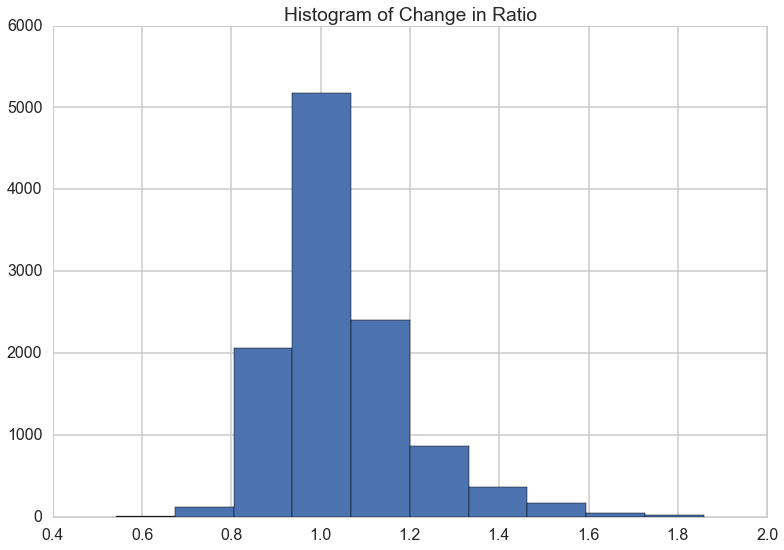

In [13]:
plt.hist(df['ratio_pct_delta'].dropna().tolist());
plt.title('Histogram of Change in Ratio');

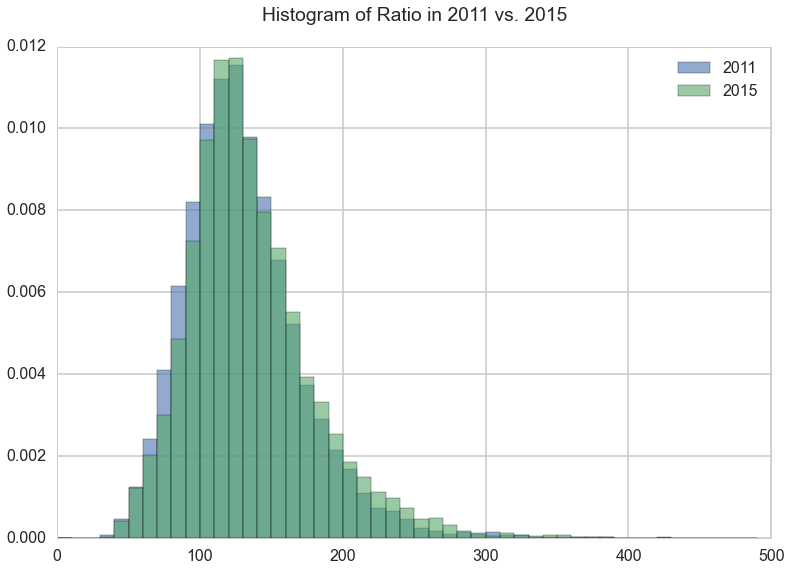

In [14]:
setbins = range(0,500,10)
plt.hist(df['ratio_2011'].dropna().tolist(), bins = setbins, normed=True, alpha=0.6, label='2011');
plt.hist(df['ratio_2015'].dropna().tolist(), bins = setbins, normed=True, alpha=0.6, label='2015');
plt.title('Histogram of Ratio in 2011 vs. 2015\n');
plt.legend();

In [15]:
df.to_pickle('data/housing_rental_ratio.pkl')

# Features: Business Metrics

We felt that an important determinant of housing/rental prices in a region might be business metrics for that region. These include the number of businesses, number of employed persons, first quarter pay, and annual payroll for businesses in that region (zipcode). We took this data from American Fact Finder (which is based off of the US Census).

In [16]:
bus_data_raw = pd.read_csv('data/BP_2010_00CZ1_with_ann.csv')

IOError: File data/BP_2010_00CZ1_with_ann.csv does not exist